In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


## Carga de datos

In [2]:
df = pd.read_csv("../../data/raw/usgs/usgs_data.csv")
df.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='str')

In [3]:
# Columnas de interés

cols = [
    "time",
    "latitude",
    "longitude",
    "mag",
    "depth",
    "magType"
]

df = df[cols]
df

,time,latitude,longitude,mag,depth,magType
0,2026-01-01T12:37:04.252Z,10.5015,-72.0685,4.6,10.000,mb
1,2025-12-25T02:38:27.062Z,6.6699,-72.9808,4.3,173.442,mb
2,2025-12-21T14:05:32.344Z,2.9645,-75.2202,4.1,58.194,mb
3,2025-12-19T21:59:54.515Z,-0.7114,-78.0227,5.1,10.000,mww
4,2025-12-17T23:07:46.062Z,6.7182,-82.5956,5.6,10.000,mww
...,...,...,...,...,...,...
2543,2015-01-10T06:17:55.370Z,8.4627,-77.1279,4.4,39.860,mb
2544,2015-01-10T03:05:59.200Z,-3.3631,-76.7936,4.4,71.730,mb
2545,2015-01-07T05:36:07.230Z,5.3788,-82.5474,5.0,10.000,mb
2546,2015-01-07T05:07:07.510Z,5.9045,-82.6576,6.5,8.000,mww


In [4]:
df_insqui = pd.read_csv("../../data/raw/nasa/coord_index.csv")
df_insqui

,row_id,tipo_actividad,latitud,longitud,lat_r,lon_r,coord_hash
0,0,Administrativa,3.41,-76.53,3.41,-76.53,75246e90e485
1,1,Administrativa,4.62,-74.11,4.62,-74.11,a71c8bc52a66
2,2,Administrativa,4.71,-74.23,4.71,-74.23,be6b4f99fea5
3,3,Administrativa,4.81,-74.10,4.81,-74.10,ac2a0153bf6b
4,4,Administrativa,4.81,-75.72,4.81,-75.72,6a956df3c5d9
...,...,...,...,...,...,...,...
385,385,Producción,10.90,-74.88,10.90,-74.88,c35a5af557e6
386,386,Producción,10.91,-74.79,10.91,-74.79,f482b38c33e4
387,387,Producción,10.98,-74.82,10.98,-74.82,a0137c350549
388,388,Producción,11.23,-74.19,11.23,-74.19,8521e6fdb4ca


## Análisis de calidad

In [5]:
df.describe()

,latitude,longitude,mag,depth
count,2548.000000,2548.000000,2548.000000,2548.000000
mean,3.718093,-77.121056,4.500196,65.009762
std,4.616935,3.682146,0.455594,62.052195
min,-5.408200,-82.787900,2.500000,1.702000
25%,-0.817175,-80.288350,4.300000,10.000000
50%,5.348650,-77.578150,4.400000,35.000000
75%,6.907175,-73.110250,4.600000,140.637500
max,13.202200,-66.819100,7.800000,239.400000


In [6]:
print(df.dtypes)

time             str
latitude     float64
longitude    float64
mag          float64
depth        float64
magType          str
dtype: object


In [7]:
df["time"] = pd.to_datetime(df["time"])

## Transformación

In [8]:
# Función para calcular la distancia haversine

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra
    R = 6371  # km
    # Convertir grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencias
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


In [9]:
# Variables de filtrado
RADIO_KM = 100 # Radio en kilómetros de influencia o afectación, nivel local o regional
MAG_MIN = 2.5 # Magnitud mínima, primer ensayo con valor mínimo

In [19]:
# Cálculo de características por cada ubicación de interés
features = []

# Fecha máxima en el dataset de sismos
fecha_max = df["time"].max()

# Iterar sobre cada ubicación 
for _, ins in df_insqui.iterrows():

    # Calcular distancias
    dist = haversine(
        ins["latitud"], ins["longitud"],
        df["latitude"], df["longitude"]
    )

    # Filtrar sismos dentro del radio de interés
    s = df[dist <= RADIO_KM]

    # Filtrar por magnitud mínima
    if len(s) == 0:
        features.append({
            "row_id": ins["row_id"],
            "n_sismos_M4": 0,
            "n_sismos_M5": 0,
            "mag_max": 0,
            "mag_mean": 0,
            "depth_mean": 0,
            "pct_superficiales": 0,
            "years_since_last_M5": 0
        })
        continue
    
    # Sismos con magnitud >= MAG_MIN
    s_M5 = s[s["mag"] >= MAG_MIN]

    # Tiempo desde el último sismo de magnitud >= MAG_MIN
    years_last = (
        (fecha_max - s_M5["time"].max()).days / 365
        if len(s_M5) > 0 else 0
    )

    # Agregar características
    features.append({
        "row_id": ins["row_id"],
        "n_sismos_M4": len(s),
        "n_sismos_M5": len(s_M5),
        "mag_max": s["mag"].max(),
        "mag_mean": s["mag"].mean(),
        "depth_mean": s["depth"].mean(),
        "pct_superficiales": (s["depth"] < 30).mean(),
        "years_since_last_M5": years_last
    })

df_seismic["years_since_last_M5"] = df_seismic["years_since_last_M5"].fillna(0)

df_seismic = pd.DataFrame(features)
df_seismic

,row_id,n_sismos_M4,n_sismos_M5,mag_max,mag_mean,depth_mean,pct_superficiales,years_since_last_M5
0,0,24,24,5.6,4.629167,103.410167,0.125000,0.164384
1,1,26,26,6.1,4.503846,54.055038,0.576923,0.479452
2,2,25,25,6.1,4.492000,61.754040,0.480000,0.479452
3,3,29,29,6.1,4.489655,58.503138,0.517241,0.479452
4,4,46,46,6.1,4.543478,98.812261,0.130435,0.391781
...,...,...,...,...,...,...,...,...
385,385,4,4,4.5,4.225000,38.115500,0.250000,3.019178
386,386,4,4,4.5,4.225000,38.115500,0.250000,3.019178
387,387,4,4,4.5,4.225000,38.115500,0.250000,3.019178
388,388,10,10,4.9,4.440000,21.246200,0.700000,1.002740


In [20]:
df_seismic.describe()

,row_id,n_sismos_M4,n_sismos_M5,mag_max,mag_mean,depth_mean,pct_superficiales,years_since_last_M5
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,194.500000,36.505128,36.505128,5.420256,4.359237,64.058357,0.330697,0.641391
std,112.727548,80.506965,80.506965,1.118333,0.817487,32.433432,0.209752,0.949913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97.250000,18.000000,18.000000,5.400000,4.473077,43.438850,0.133333,0.164384
50%,194.500000,24.000000,24.000000,5.600000,4.511111,58.503138,0.388889,0.298630
75%,291.750000,28.000000,28.000000,6.100000,4.561111,95.297845,0.458333,0.479452
max,389.000000,522.000000,522.000000,6.300000,4.753333,152.511345,1.000000,6.830137


In [21]:
df_seismic.to_csv("../../data/transformed/usgs/usgs_seismic_clean.csv", index=False)

In [12]:
df_map = df_insqui.merge(df_seismic, on="row_id", how="left")


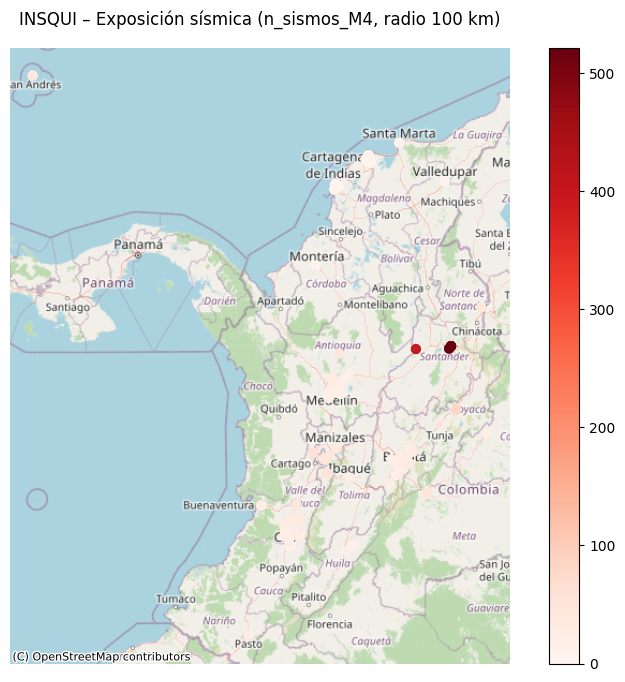

In [13]:
# Visualización de la exposición sísmica

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(
    ax=ax,
    column="n_sismos_M4",
    cmap="Reds",
    legend=True,
    markersize=40,
    alpha=0.8
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_title("INSQUI – Exposición sísmica (n_sismos_M4, radio 100 km)")

plt.show()

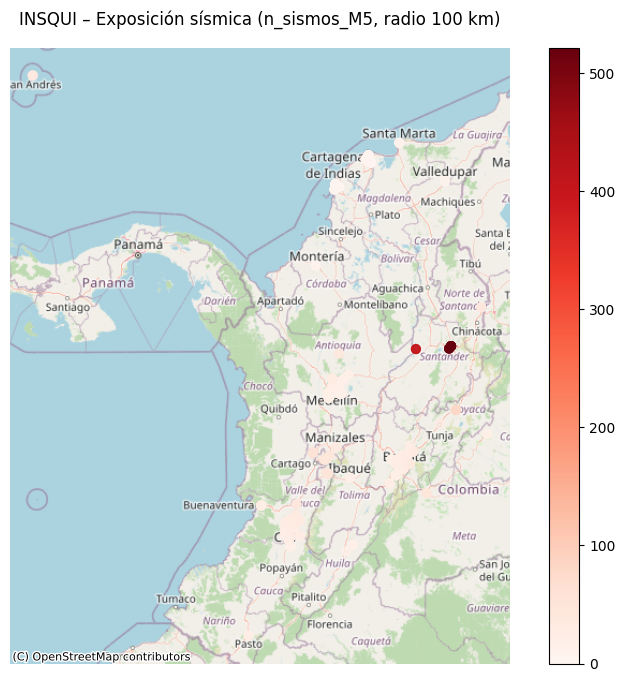

In [14]:
# Visualización de la exposición sísmica

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(
    ax=ax,
    column="n_sismos_M5",
    cmap="Reds",
    legend=True,
    markersize=40,
    alpha=0.8
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_title("INSQUI – Exposición sísmica (n_sismos_M5, radio 100 km)")

plt.show()

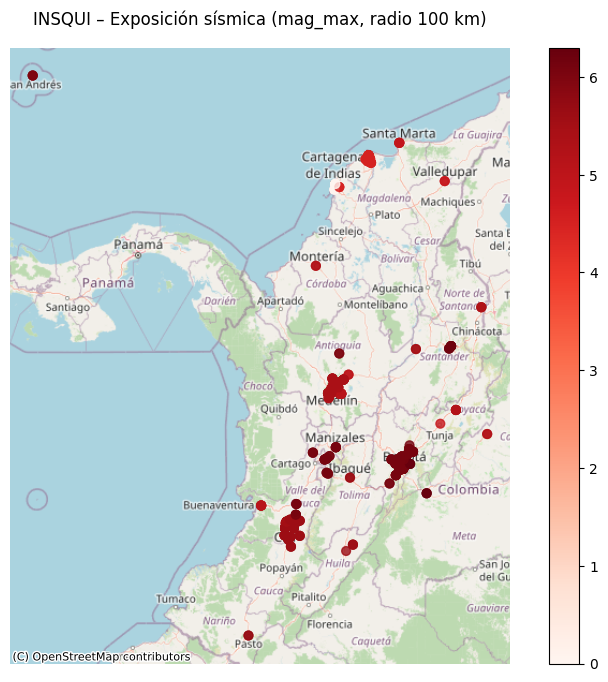

In [15]:
# Visualización de la exposición sísmica

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map["longitud"], df_map["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(
    ax=ax,
    column="mag_max",
    cmap="Reds",
    legend=True,
    markersize=40,
    alpha=0.8
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_title("INSQUI – Exposición sísmica (mag_max, radio 100 km)")

plt.show()